# 训练分类器

就是这个。 您已经了解了如何定义神经网络，计算损失并更新网络的权重。

现在您可能在想，

<h2>数据呢？</h2>

通常，当您必须处理图像，文本，音频或视频数据时，可以使用将数据加载到 NumPy 数组中的标准 Python 包。 然后，您可以将该数组转换为 ```torch.*Tensor``` 。

> * 对于图像，Pillow，OpenCV 等包很有用
> * 对于音频，请使用 SciPy 和 librosa 等包
> * 对于文本，基于 Python 或 Cython 的原始加载，或者 NLTK 和 SpaCy 很有用

专门针对视觉，我们创建了一个名为 ```torchvision``` 的包，其中包含用于常见数据集（例如 Imagenet，CIFAR10，MNIST 等）的数据加载器，以及用于图像（即 ```torchvision.datasets``` 和 ```torch.utils.data.DataLoader``` ）的数据转换器。

这提供了极大的便利，并且避免了编写样板代码。

在本教程中，我们将使用 CIFAR10 数据集。 它具有以下类别：“飞机”，“汽车”，“鸟”，“猫”，“鹿”，“狗”，“青蛙”，“马”，“船”，“卡车”。 CIFAR-10 中的图像尺寸为 ```3x32x32``` ，即尺寸为 ```32x32``` 像素的 3 通道彩色图像。

![1.4.1](1.4.1.png)

cifar10

## 训练图像分类器

我们将按顺序执行以下步骤：
1. 使用 ```torchvision``` 加载并标准化 CIFAR10 训练和测试数据集
2. 定义卷积神经网络
3. 定义损失函数
4. 根据训练数据训练网络
5. 在测试数据上测试网络

### 1.加载并标准化 CIFAR10

使用 ```torchvision``` ，加载 CIFAR10 非常容易。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

TorchVision 数据集的输出是 ```[0, 1]``` 范围的PILImage图像。 我们将它们转换为归一化范围 ```[-1, 1]``` 的张量。 .. 注意：

If running on Windows and you get a BrokenPipeError, try setting
the num_worker of torch.utils.data.DataLoader() to 0.

如果你在Windows上运行，并出现BrokenPipeError，尝试设置torch.utils.data.DataLoader()的num_worker为0


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


让我们展示一些训练图像，很有趣。

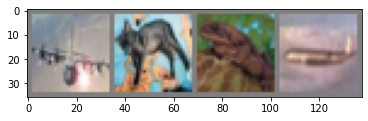

plane   cat  frog plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## 2.定义卷计算机网络

之前从“神经网络”部分复制神经网络，然后对其进行修改以获取 3 通道图像（而不是定义的 1 通道图像）。

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## 3.定义损失函数和优化器

让我们使用分类交叉熵损失和带有动量的 SGD。

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum =0.9)

## 4.训练网络

这是事情开始变得有趣的时候。 我们只需要遍历数据迭代器，然后将输入馈送到网络并进行优化即可。

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.066
[1,  4000] loss: 1.946
[1,  6000] loss: 1.946
[1,  8000] loss: 1.969
[1, 10000] loss: 1.969
[1, 12000] loss: 1.963
[2,  2000] loss: 1.961
[2,  4000] loss: 1.960
[2,  6000] loss: 1.965
[2,  8000] loss: 1.975
[2, 10000] loss: 1.958
[2, 12000] loss: 2.020
Finished Training


让我们快速保存我们训练过的模型：

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


## 5.根据测试数据测试网络

我们已经在训练数据集中对网络进行了 2 次训练。 但是我们需要检查网络是否学到了什么。

我们将通过预测神经网络输出的类别标签并根据实际情况进行检查来进行检查。 如果预测正确，则将样本添加到正确预测列表中。

好的，第一步。 让我们显示测试集中的图像以使其熟悉。

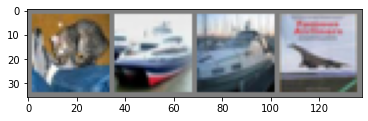

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

接下来，让我们重新加载保存的模型（注意：这里不需要保存和重新加载模型，我们只是为了说明如何这样做）：

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

好的，现在让我们看看神经网络对以上这些示例的看法：

In [10]:
outputs = net(images)


输出是 10 类的能量。 一个类别的能量越高，网络就认为该图像属于特定类别。 因此，让我们获取最高能量的指数：

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:    car truck truck  ship


结果似乎还不错。

让我们看一下网络在整个数据集上的表现。

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 28 %


看起来比偶然更好，准确率是 10%（从 10 个类中随机选择一个类）。 好像网络学到了一些东西。

嗯，哪些类的表现良好，哪些类的表现不佳：

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 18 %
Accuracy of   car : 19 %
Accuracy of  bird :  4 %
Accuracy of   cat : 11 %
Accuracy of  deer : 12 %
Accuracy of   dog : 23 %
Accuracy of  frog : 64 %
Accuracy of horse : 31 %
Accuracy of  ship : 44 %
Accuracy of truck : 50 %


好的，那下一步呢？

我们如何在 GPU 上运行这些神经网络？

## 6.在GPU上进行训练

就像将张量转移到 GPU 上一样，您也将神经网络转移到 GPU 上。

如果可以使用 CUDA，首先将我们的设备定义为第一个可见的 cuda 设备：

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


本节的其余部分假定device是 CUDA 设备。

然后，这些方法将递归遍历所有模块，并将其参数和缓冲区转换为 CUDA 张量：

In [15]:
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

请记住，您还必须将每一步的输入和目标也发送到 GPU：

In [16]:
inputs, labels = data[0].to(device), data[1].to(device)
